In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imsave

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# LeNet Model definition (simple Convnet model)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)


# Initialize the network
model = Net().to(device)

# Load the pretrained model
pretrained_model = "lenet_mnist_model.pth"
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

In [4]:
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [44]:
#Fast Gradient Sign Method

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [45]:
def generate_adversarial(model, device, test_loader, epsilon=0.2):

    correct = 0 #accuracy counter
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1

        else:
            # Save some adv examples
            if len(adv_examples) < 30:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate accuracy for a new, perturbed test set
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {}/{} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return adv_examples

In [46]:
adv_examples = generate_adversarial(model, device, test_loader)

Epsilon: 0.2	Test Accuracy = 4301/10000 = 0.4301


Let's see how the attacked images are classified:

In [48]:
for i in range(5):
    print (f'Original label: {adv_examples[i][0]} and after attack: {adv_examples[i][1]}')

Original label: 7 and after attack: 5
Original label: 4 and after attack: 8
Original label: 2 and after attack: 8
Original label: 3 and after attack: 8
Original label: 1 and after attack: 2


and how they look

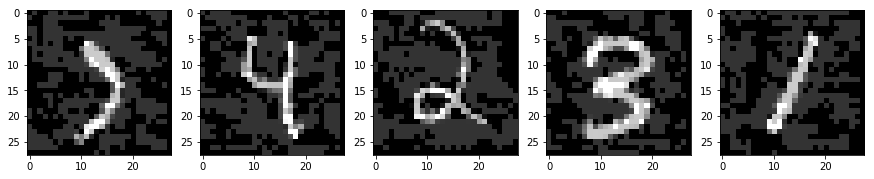

In [49]:
fig = plt.figure(figsize=(15,11))
for i in range(5):
    fig.add_subplot(1,5,i+1)
    plt.imshow(adv_examples[i][2], cmap="gray")

Saving 30 adversarial examples to files

In [50]:
for i in range(30):
    filename = f'./generated_adversarials/adv_example_{i}.png'
    imsave(filename, adv_examples[i][2])

/Users/pawelmorawiecki/Python3_env/Python3_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
